In [1]:
# general setup
import matplotlib.pyplot as plt
import numpy as np
import copy

%matplotlib inline

# 1. 3x3 Grid World

In [2]:
class gridWorld:
    def __init__(self, rows, cols, gamma):
        self.action = [[0,1], [1,0], [0,-1], [-1,0]]       
        self.rows = rows
        self.cols = cols
        self.gamma = gamma
        self.total_state = self.rows * self.cols
        self.check = np.zeros([3,3])
        
    # state to coordinates
    def state2xy(self, state_No):
        x = (state_No) // self.cols
        y = state_No % self.cols
        return [x,y]
    
    # coordinates to state
    def xy2state(self, s):
        return s[0] * self.cols + s[1]
    
    # transition for bellman expectation equation
    def trasition(self, s, s_):
        if s==[0,0] and s_==[2,2]:
            return 1
        elif s==[0,0] and s_!=[2,2]:
            return 0
        elif s==s_ and s in [[0,1], [1,0], [1,2], [2,1]]:
            return 0.25 * self.gamma
        elif s==s_ and s in [[0,2], [2,0], [2,2]]:
            return 0.5 * self.gamma
        elif s[0]==s_[0] and (s[1]==s_[1]+1 or s[1]==s_[1]-1):
            return 0.25 * self.gamma
        elif s[1]==s_[1] and (s[0]==s_[0]+1 or s[0]==s_[0]-1):
            return 0.25 * self.gamma
        else:
            return 0
    
    # reward for bellman expectation equation
    def reward(self, s):
        if s==[0,0]:
            return 10
        elif s in [[0,1], [1,0], [1,2], [2,1]]:
            return -0.25
        elif s in [[0,2], [2,0], [2,2]]:
            return -0.5
        else:
            return 0
        
    # Bellman expectation EQ
    def Bellman_Exp_EQ(self):
        P = np.zeros([self.total_state, self.total_state])
        for i in range(self.total_state):
            for j in range(self.total_state):
                P[i,j] = self.trasition(self.state2xy(i), self.state2xy(j))
        print('P: ')
        print(P)
        R = np.zeros(self.total_state) 
        for i in range(self.total_state):
            R[i] = self.reward(self.state2xy(i))
        print('R: ')
        print(R)
        I = np.eye(self.total_state)
        return np.reshape(np.linalg.inv(I - P) @ R, newshape=[self.rows, self.cols])
    
    # transition and reward for general purposes
    def transition_and_reward(self, s, action):
        if s == [0,0]:
            return 10, 1, [2,2] 
        elif s == [1,1]:
            s_ = np.add(s, action).tolist()
            return 0, self.gamma, s_
        else:
            s_ = np.add(s, action).tolist()
            if s_[0] < 0 or s_[1] < 0:
                return -1, self.gamma, s
            try:
                tmp = self.check[s_[0], s_[1]]
                return 0, self.gamma, s_
            except:
                return -1, self.gamma, s

    # model-based prediction: iterative policy evaluation
    def iterative_policy_evaluation(self, epsilon=1e-4):
        old_v = np.zeros(self.total_state)
        v = np.ones(self.total_state)
        P = np.zeros([self.total_state, self.total_state])
        for i in range(self.total_state):
            for j in range(self.total_state):
                P[i,j] = self.trasition(self.state2xy(i), self.state2xy(j))
        print('P: ')
        print(P)
        R = np.zeros(self.total_state) 
        for i in range(self.total_state):
            R[i] = self.reward(self.state2xy(i))
        print('R: ')
        print(R)
        while np.linalg.norm(v-old_v, ord=2) > epsilon:
            old_v = np.copy(v)
            v = R + P @ old_v
        return np.reshape(v, newshape=[self.rows, self.cols])
    
    # model-based control: policy_iteration
    def policy_iteration(self, epsilon=1e-4):
        old_policy = [[0,1] for i in range(9)]
        policy = [[1,0] for i in range(9)]
        v = np.ones(self.total_state)
        while np.any(policy != old_policy):
            # policy evaluation
            old_v = np.zeros(self.total_state)
            while np.linalg.norm(v-old_v, ord=2) > epsilon:
                old_v = np.copy(v)
                for i in range(len(v)):
                    s = self.state2xy(i)
                    r, gamma, s_ = self.transition_and_reward(s, policy[i])
                    v[i] = r + gamma * old_v[self.xy2state(s_)]
            
            # policy improvement
            old_policy = np.copy(policy)
            for i in range(len(policy)):
                potential_actions = np.zeros(4)
                for j in range(4):
                    r, gamma, s_ = self.transition_and_reward(self.state2xy(i), 
                                                              self.action[j])
                    potential_actions[j] = r + gamma * v[self.xy2state(s_)]
                policy[i] = self.action[np.argmax(potential_actions)]

        policy[0] = None
        v = np.round(v, 3)
        return np.reshape(v, newshape=[self.rows, self.cols]),\
               np.reshape(policy, newshape=[self.rows, self.cols])

In [3]:
grid33 = gridWorld(3, 3, 0.9)

In [4]:
v_pi = grid33.Bellman_Exp_EQ()
print('V:')
print(v_pi)

P: 
[[0.    0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.225 0.225 0.225 0.    0.225 0.    0.    0.    0.   ]
 [0.    0.225 0.45  0.    0.    0.225 0.    0.    0.   ]
 [0.225 0.    0.    0.225 0.225 0.    0.225 0.    0.   ]
 [0.    0.225 0.    0.225 0.    0.225 0.    0.225 0.   ]
 [0.    0.    0.225 0.    0.225 0.225 0.    0.    0.225]
 [0.    0.    0.    0.225 0.    0.    0.45  0.225 0.   ]
 [0.    0.    0.    0.    0.225 0.    0.225 0.225 0.225]
 [0.    0.    0.    0.    0.    0.225 0.    0.225 0.45 ]]
R: 
[10.   -0.25 -0.5  -0.25  0.   -0.25 -0.5  -0.25 -0.5 ]
V:
[[ 8.69883122  2.42401952 -0.1134855 ]
 [ 2.42401952  0.87516596 -0.47920629]
 [-0.1134855  -0.47920629 -1.30116878]]


In [5]:
v_iterative = grid33.iterative_policy_evaluation()
print('V:')
print(v_iterative)

P: 
[[0.    0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.225 0.225 0.225 0.    0.225 0.    0.    0.    0.   ]
 [0.    0.225 0.45  0.    0.    0.225 0.    0.    0.   ]
 [0.225 0.    0.    0.225 0.225 0.    0.225 0.    0.   ]
 [0.    0.225 0.    0.225 0.    0.225 0.    0.225 0.   ]
 [0.    0.    0.225 0.    0.225 0.225 0.    0.    0.225]
 [0.    0.    0.    0.225 0.    0.    0.45  0.225 0.   ]
 [0.    0.    0.    0.    0.225 0.    0.225 0.225 0.225]
 [0.    0.    0.    0.    0.    0.225 0.    0.225 0.45 ]]
R: 
[10.   -0.25 -0.5  -0.25  0.   -0.25 -0.5  -0.25 -0.5 ]
V:
[[ 8.69914207  2.42431251 -0.11319971]
 [ 2.42431251  0.87545285 -0.47892324]
 [-0.11319971 -0.47892324 -1.30088793]]


In [12]:
v_policy_iteration, policy_policy_iteration = grid33.policy_iteration()
print('V_policy-iter:')
print(v_policy_iteration)
print('Policy:')
print(policy_policy_iteration)

V_policy-iter:
[[29.078 26.17  23.553]
 [26.17  23.553 21.198]
 [23.553 21.198 19.078]]
Policy:
[[None list([0, -1]) list([0, -1])]
 [list([-1, 0]) list([0, -1]) list([0, -1])]
 [list([-1, 0]) list([0, -1]) list([0, -1])]]


# 2. Gambler's Problem

In [7]:
class gambler:
    def __init__(self, ph):
        self.ph = ph
    
    # transition and reward
    def transition_and_reward(self, s, action):
        s_ = s + action
        if s_ == 100:
            return 0, s-action, 1, s_
        else:
            return 0, s-action, 0, s_
    
    # model-based control: value_iteration
    def value_iteration(self, epsilon=1e-3):
        v = np.zeros(101)
        old_v = np.ones(101)
        policy = np.zeros(101)
        old_policy = np.ones(101)
        plot_v = []

        round = 0
        while np.linalg.norm(v-old_v, ord=2) > epsilon:
            old_v = np.copy(v)
            for i in range(1,len(v)-1):
                # one sweep over value vector
                tmp_v = [0] * (min(i,100-i)+1)
                for action in range(min(i,100-i)+1):
                    r1, s1, r2, s2 = self.transition_and_reward(i, action)
                    tmp_v[action] = (1-self.ph) * (r1+old_v[s1]) + \
                                    self.ph * (r2+old_v[s2])
                
                # value vector update
                v[i] = np.max(tmp_v)
            round += 1

            if round in [1,2,3,32]:
                plot_v.append(np.round(v,3))
        plot_v.append(np.round(v,3))
        
        
        # pocily extraction
        old_policy = np.copy(policy)
        for i in range(1,len(v)-1):
            potential_actions = [0] * (min(i,100-i)+1)
            for action in range(min(i,100-i)+1):
                r1, s1, r2, s2 = self.transition_and_reward(i, action)
                potential_actions[action] = (1-self.ph) * (r1+v[s1]) + \
                                            self.ph * (r2+v[s2])

            policy[i] = np.argmax(potential_actions)
                    
        return plot_v, policy

<BarContainer object of 99 artists>

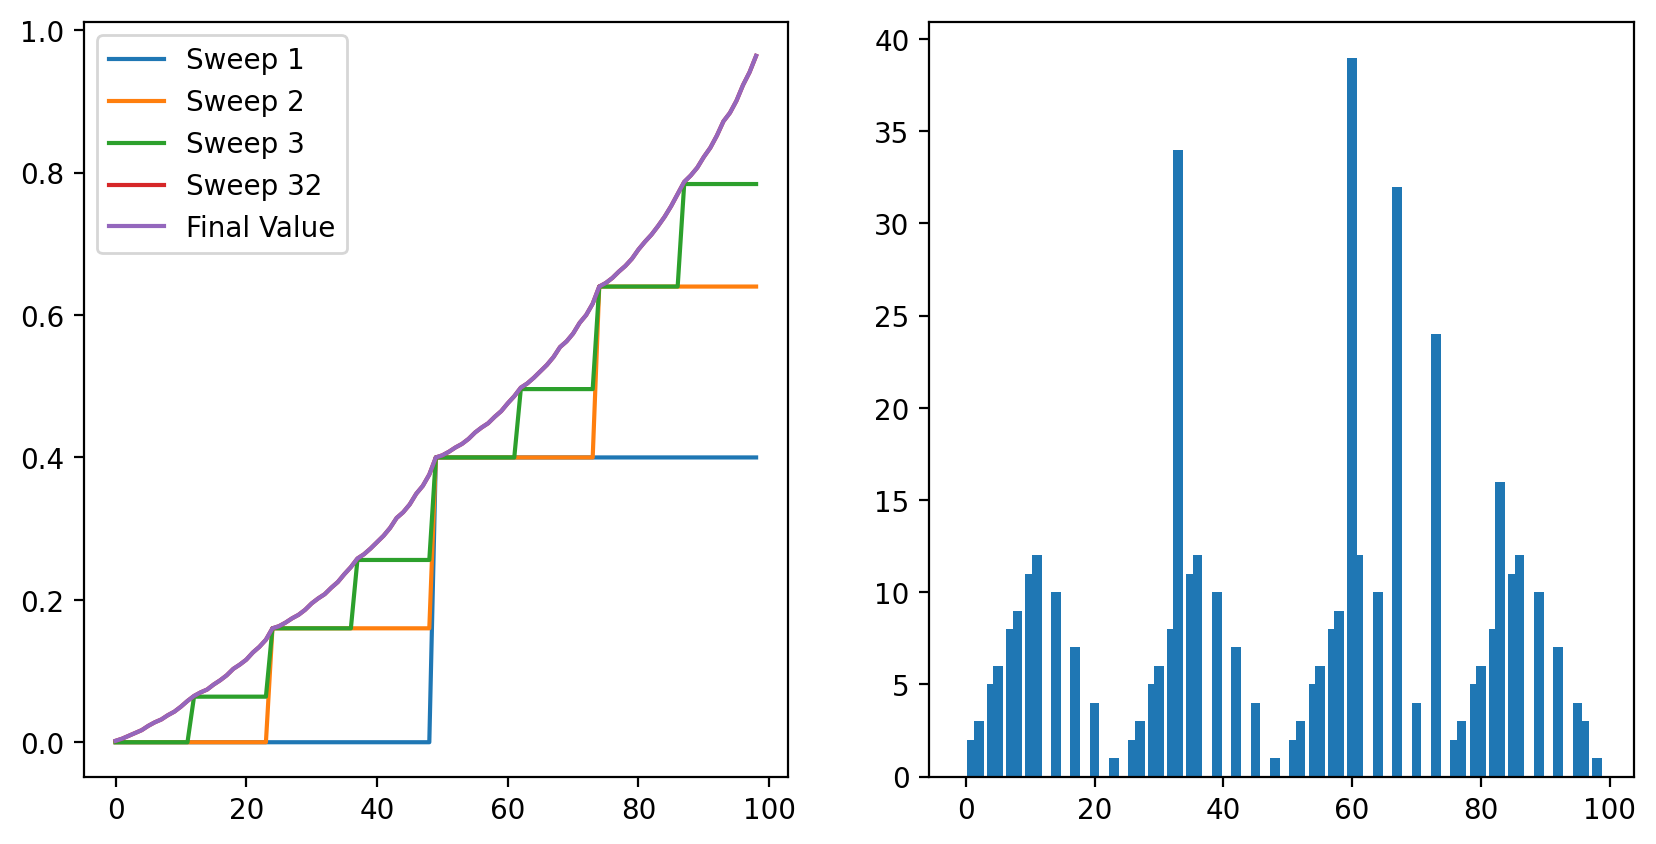

In [8]:
agent = gambler(ph=0.4)
V, policy = agent.value_iteration(epsilon=1e-13)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=200)
ax[0].plot(np.arange(99), V[0][1:-1], label='Sweep 1')
ax[0].plot(np.arange(99), V[1][1:-1], label='Sweep 2')
ax[0].plot(np.arange(99), V[2][1:-1], label='Sweep 3')
ax[0].plot(np.arange(99), V[3][1:-1], label='Sweep 32')
ax[0].plot(np.arange(99), V[4][1:-1], label='Final Value')
ax[0].legend()
ax[1].bar(np.arange(99), policy[1:-1], width=1.5, label='Pocily')

<BarContainer object of 99 artists>

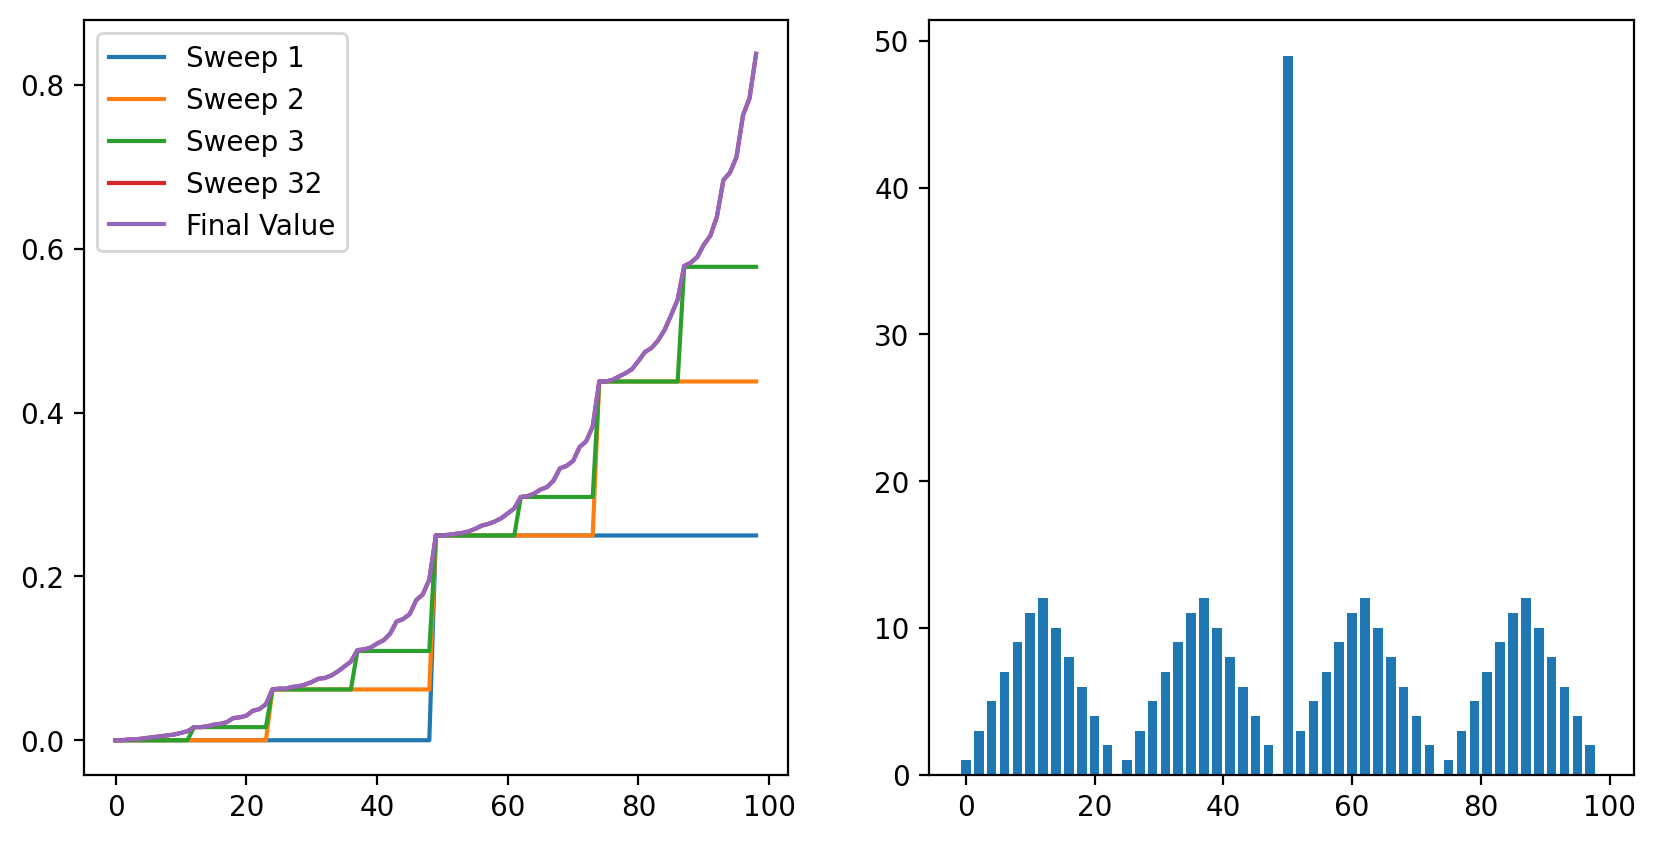

In [9]:
agent = gambler(ph=0.25)
V, policy = agent.value_iteration(epsilon=1e-14)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=200)
ax[0].plot(np.arange(99), V[0][1:-1], label='Sweep 1')
ax[0].plot(np.arange(99), V[1][1:-1], label='Sweep 2')
ax[0].plot(np.arange(99), V[2][1:-1], label='Sweep 3')
ax[0].plot(np.arange(99), V[3][1:-1], label='Sweep 32')
ax[0].plot(np.arange(99), V[4][1:-1], label='Final Value')
ax[0].legend()
ax[1].bar(np.arange(99), policy[1:-1], width=1.5, label='Pocily')

<BarContainer object of 99 artists>

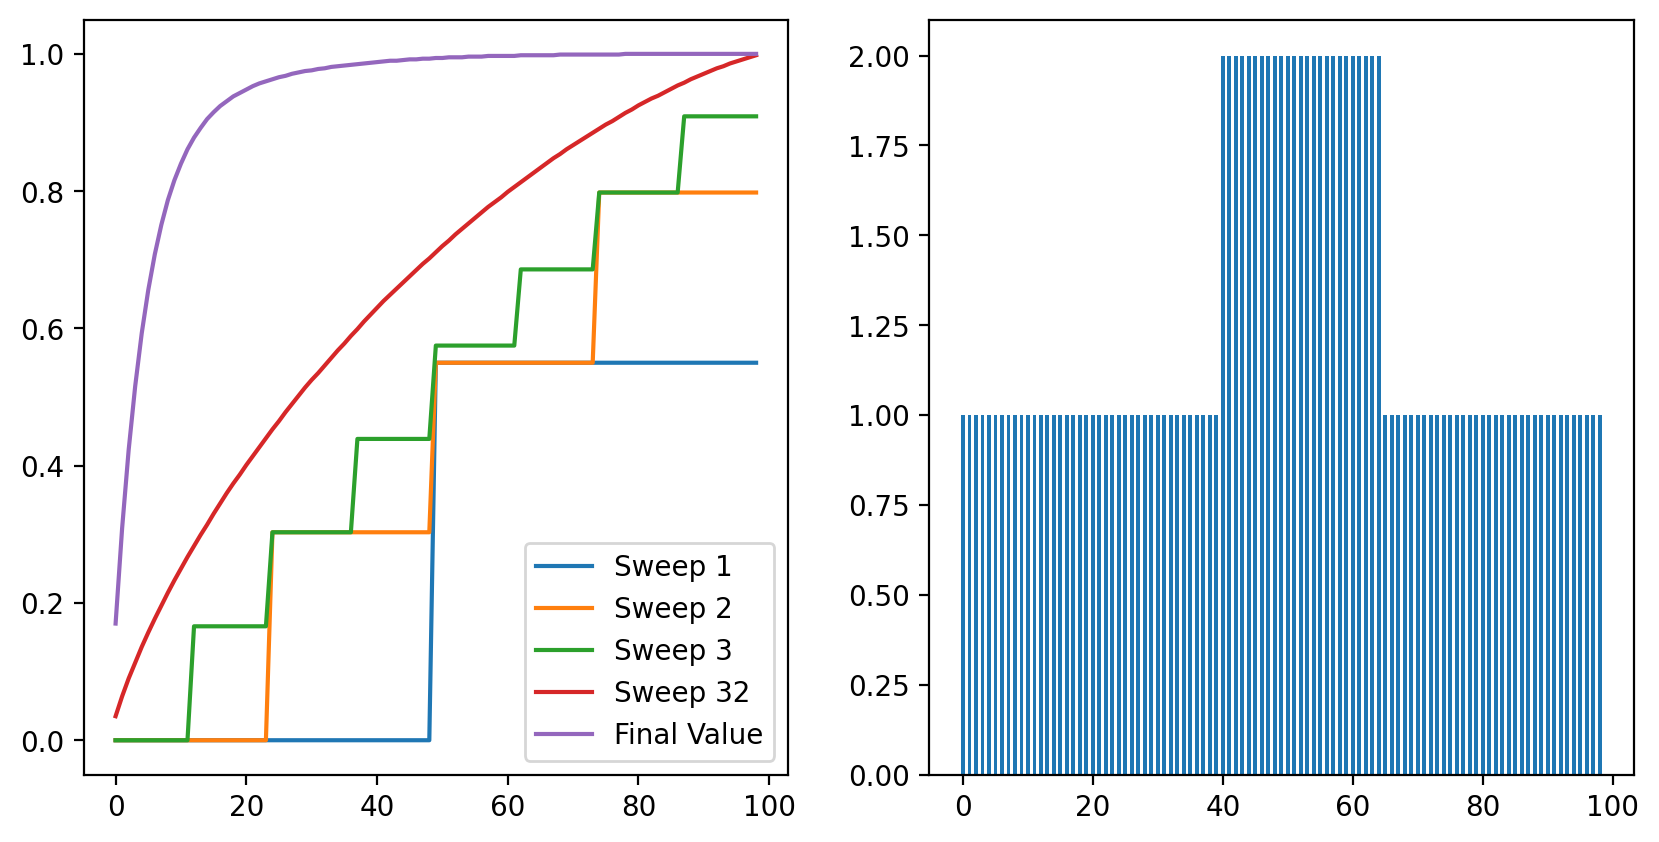

In [10]:
agent = gambler(ph=0.55)
V, policy = agent.value_iteration(epsilon=1e-3)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=200)
ax[0].plot(np.arange(99), V[0][1:-1], label='Sweep 1')
ax[0].plot(np.arange(99), V[1][1:-1], label='Sweep 2')
ax[0].plot(np.arange(99), V[2][1:-1], label='Sweep 3')
ax[0].plot(np.arange(99), V[3][1:-1], label='Sweep 32')
ax[0].plot(np.arange(99), V[4][1:-1], label='Final Value')
ax[0].legend()
ax[1].bar(np.arange(99), policy[1:-1], width=0.6, label='Pocily')